# METHODES MATRICIELLES POUR LE CALCUL INTENSIF
## P.A. Boucard
### *Très largement inspiré du cours donné par P. Gosselet jusqu'en 2018*
Ce cours est divisé en 7 grands chapitres :
- Calcul numérique
- Algèbre
- Conditionnement
- Généralités sur la résolution des systèmes linéaires
- Solveurs directs
- Solveurs itératifs
- Problèmes aux valeurs propres

# Calcul numérique

## Nombres à virgule flottante

### Les nombres à virgule flottante

Un nombre à virgule flottante est de la forme $x=s.m.\beta^e$ : $s$ est
le signe de $x$, $m$ est la mantisse, $\beta$ la base (en pratique $2$)
et $e$ l'exposant. La mantisse $m$ est décrite par au plus $p$ chiffres
en base $\beta$ ($m$ est un nombre à virgule) et
$e_{\min}\leqslant e\leqslant e_{\max}$, $e$ est lui aussi stocké en
base $\beta$ sous la forme de $d$ chiffres et un signe. Un dernier
détail consiste à rendre unique la représentation des nombres (parce que
$3.140\ 10^0=0.314\ 10^1$). Une solution, en base deux, est de toujours
imposer que le premier chiffre de la mantisse soit 1 (d'ailleurs ce
nombre n'est pas stocké, c'est le bit de tête implicite), on parle de
nombre normalisé. Cela limite la précision inférieure des calculs. Une
solution est de pouvoir passer en représentation dénormalisée (ce qui
permet des mantisses plus petites).

On propose de donner une représentation de nombres flottants
obtenus pour des flottants du type $x=0.d_1d_2d_3 2^e$ où les $d_i$ sont
des chiffres en base 2 et $e$ est stocké sur 2 bits
($-1\leqslant e\leqslant 2$). On voit que les flottants ne sont pas
équirépartis dans ${\mathbb{R}}$.



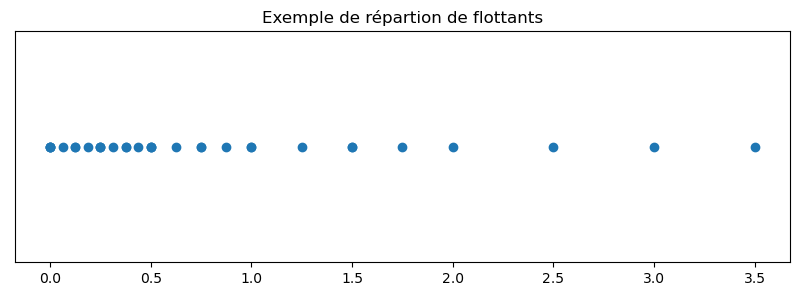

In [5]:
import matplotlib.pyplot as plt
list_values = [0, 1]
mylist =[];
myplot=[]
for i in list_values:
    for j in list_values:
           for k in list_values:
                for l in [-1, 0, 1, 2]:
                    rep_flot = ((1-i)*1/2+(1-j)*1/4+(1-k)*1/8)*2**l 
                    mylist = mylist + [rep_flot]
                    myplot = myplot + [1]
mylist.sort
plt.figure(figsize=(10,3))
plt.title("Exemple de répartion de flottants")
plt.scatter(mylist,myplot)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_ticks([])
plt.show()

Adapter ce petit programme pour représenter des entiers type $x=0.d_1d_2d_3d_4 2^e$ où les $d_i$ sont
des chiffres en base 2 et $e$ est stocké sur 3 bits
($-3\leqslant e\leqslant 4$).

Soit $\mathbb{F}\subset\mathbb{Q}$ l'ensemble des flottants.
Malheureusement, cet espace n'a pas de belle structure algébrique quand
on le munit des opérations usuelles. En particulier, il n'est pas stable
par les opérations usuelles. Par exemple 1 et
$(10)_{decimal}=(1010)_{binaire}$ sont des flottants mais
$(1/10)_{decimal}=0.0001100110011\ldots$ n'est pas flottant. On doit
donc systématiquement ajouter une étape d'arrondi pour pouvoir
représenter le résultat d'une opération dans $\mathbb{F}$. Outre des
problèmes de précison, cet arrondi entraîne la perte de certaines
propriétés notamment les opérations ne sont plus associatives (ni
distributives). Cela signifie que l'ordre dans lequel on conduit les
opérations est primordial. Par exemple, que vaut : $0.1 + 10^{20} - 10^{20}$...

On constate clairement la différence entre $0.1 + (10^{20} - 10^{20}) = 0.1, \qquad (0.1 + 10^{20}) - 10^{20} = 0.$
Pour les flottants, si on ne met pas de parenthèses pour forcer l'ordre
d'évaluation des opérations, on ne peut pas garantir la reproductibilité
d'un résultat.

### La norme IEEE 754

Quatre formats en base 2 sont prévus (voir table
ci-dessous) :
simple précision (correspondant généralement au type *float* en C),
simple précision étendue (obsolète), double précision (correspondant
généralement au type *double* en C) et double précision étendue
(*extended* en anglais). La quadruple précision a été introduite plus
récemment. La norme prévoit également les nombres spéciaux $-\infty$,
$+\infty$ et NaN (*not a number*) sur lesquels les opérations standards
sont définies (+,-,\*,/). Le zéro est signé ($1/(-0)=-\infty$).

Remarque : l'exposant peut être positif ou négatif. Cependant, la représentation habituelle des nombres signés (complément à 2) rend la comparaison entre les nombres flottants un peu plus difficile. Pour régler ce problème, l'exposant est « biaisé », afin de le stocker sous forme d'un nombre non signé. Ce biais est de $2^{e−1} − 1$ ($e$ représente le nombre de bits de l'exposant) ; il s'agit donc d'une valeur constante une fois que le nombre de bits $e$ est fixé.

L'interprétation d'un nombre (autre qu'infini) est donc : valeur = signe × mantisse × $2^{(exposant − biais)}$ avec signe = ±1 et biais = $2^{e−1} − 1$.

|format|taille|précision|exposant min|exposant max|valeur max |
|:---------:|:----------------:|:-----------------------------:|:------------------:|:----------------:|:----------------------:|
| simple | 32 | 23 + 1 bits | -126 | +127 | $3.403$ $10^{38}$|
| double     | 64               |       52 + 1 bits               |        -1022       |        +1023     | $1.798$  $10^{308}$    |
| *extended* | $\geqslant$ $79$   | $\geqslant 63+1$ bits | $\leqslant$ $-16382$  | $\geqslant$ $ 16383$ | $1.190$ $10^{4932}$   |
| quadruple  | 128          |       112 + 1 bits          |        -16382   |      16383     | $1.190$ $10^{4932}$   |

<center> Norme IEEE 754</center>

Des drapeaux (*flags*) sont prévus, auxquels il est possible d'associer
des exceptions :

-   drapeau inexact quand le calcul a nécessité un arrondi,

-   drapeau opération invalide quand le calcul donne un NaN:
    $\infty/\infty$ ou $\sqrt{-1}$ ou $\infty-\infty$ ou $0/0$,

-   drapeau division par zéro,

-   drapeau débordement vers l'infini (*overflow*) quand le résultat
    d'une opération est trop grand en valeur absolue pour être
    représenté à cause de la borne supérieure des exposants
    représentables,

-   drapeau débordement vers zéro (*underflow*) quand le résultat d'une
    opération est trop petit en valeur absolue pour être représenté à
    cause de la borne inférieure des exposants représentables.

Quatre modes d'arrondi sont définis : les arrondis dirigés (vers
$-\infty$, vers $+\infty$, ou vers $0$) et l'arrondi au plus proche. Ce
dernier est ambigu quand le nombre à arrondir est équidistant de deux
flottants, la norme impose de choisir celui dont la mantisse est paire
(on parle d'arrondi pair).

Une fois le mode d'arrondi choisi, le résultat d'une opération est
parfaitement spécifié, notamment le résultat est unique, on parle
d'arrondi correct. La norme impose l'arrondi correct pour les quatre
opérations de base (addition, soustraction, multiplication, division)
ainsi que pour la racine carrée. On est donc sensé obtenir le même
résultat sur des machines différentes respectant la norme ; mais souvent
les machines utilisent des précisions intermédiaires étendues
non-normalisées et les compilateurs s'autorisent à réorganiser les
opérations (alors que les opérations flottantes perdent leur propriétés
d'associativité), sans parler des problèmes de doubles arrondis (quand,
en arrondi au plus proche, on utilise des précisions intermédiaires
différentes).

Les arrondis vers l'infini permettent une arithmétique d'intervalle
(toujours majorer ou minorer un résultat).

La norme ne spécifie rien sur les autres opérations (puissance,
exponentielle, logarithme, sinus, cosinus, etc).

On propose d'implémenter en Python une conversion décimal - binaire - décimal : il est pertinent de lire ici par exemple : https://fr.wikipedia.org/wiki/IEEE_754 les compléments d'informations en particulier le biais de l'exposant (on ne stocke pas l'exposant, mais l'esposant+127, le nombre zéro correspond à un exposant ET une mantisse nulle...) 

In [1]:
import struct
from IPython.display import display, Latex
#Conversion en binaire
def binary(num):
    convstr = ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num));
    return convstr
# Conversion
binaire=binary(1/8);
# Affichage
print ('Signe | Exposant | Mantisse')
print('  '+binaire[0:1]+'   | '+binaire[1:9]+' | '+binaire[9:])
signe=binaire[0:1]
exposant=binaire[1:9]
mantisse=binaire[9:]


Signe | Exposant | Mantisse
  0   | 01111100 | 00000000000000000000000


### Le calcul d'erreurs

Comme la propagation d'erreur d'arrondi est inévitable, l'objectif est
simplement de contrôler l'erreur. On introduit pour cela la notion d'ulp
(*unit last place*) qui est le plus petit flottant représentable sur le
squelette d'un nombre donné (c'est le poids du plus petit bit de la
mantisse d'un flottant) : si $x=1.b_{-1}...b_{1-p}\ 2^e$, alors
${\operatorname{ulp}}(x)=2^{e+1-p}$.

La façon traditionnelle d'appréhender les erreurs consiste à introduire
une erreur d'arrondi $u$ ($u$ est de l'ordre de $10^{-16}$ en double
précision). Soit $R$ une fonction d'arrondi et $x$ le résultat d'un
calcul (+,\*,/,-,$\sqrt{}$) qui n'a pas explosé, la norme garantit:
$$\left|\frac{x-R(x)}{R(x)}\right| \leqslant u, \qquad \left|\frac{x-R(x)}{x}\right| \leqslant \frac{u}{1-u}\simeq u$$

La technique d'estimation d'erreur consiste à chaque opération à insérer
un facteur $(1+\delta)$ avec $|\delta|\leqslant u$ et de voir comment
les erreurs se propagent et se cumulent.

**Exemple 1.1** ($(x+y)/2$). On va introduire $\delta_1$ pour la
division par 2 et $\delta_2$ pour l'addition $$\begin{aligned}
    R((x+y)/2) &= R(x+y)/2 * (1+\delta_1) = (x+y)(1+\delta_2)(1+\delta_1)/2 \\ 
    R((x+y)/2)-(x+y)/2 &= (\delta_1 +\delta_2 + \delta_1\delta_2)(x+y)/2 \\
    \left|\frac{R((x+y)/2)-(x+y)/2}{(x+y)/2}\right| &\leqslant 2u
\end{aligned}$$ On néglige l'ordre 2. On voit que l'erreur est bornée
par $2u$.

**Exemple 1.2** ($(a^2-b^2)$ -- effet de cancellation). On a ici deux
façon de calculer. $$\begin{aligned}
    R(a^2-b^2)=(a^2(1+\delta_1)-b^2(1+\delta_2))(1+\delta_3)\\
    \left|R(a^2-b^2)-(a^2-b^2)\right|\leqslant 2u(a^2\mathbf{+}b^2)\\
    \left|\frac{R(a^2-b^2)-(a^2-b^2)}{a^2-b^2}\right|\leqslant 2u\frac{a^2\mathbf{+}b^2}{|a^2-b^2|}\\
    \end{aligned}$$ Le $+$ est dû au fait que les $\delta$ peuvent être
négatifs.

Le facteur $\frac{a^2\mathbf{+}b^2}{|a^2-b^2|}$ est le conditionnement
de l'opération. On voit que l'erreur peut exploser si $a$ et $b$ sont
proches. Par contre si on modifie la façon de calculer:
$$\begin{aligned}
R((a-b)(a+b))=R(a-b)R(a+b)(1+\delta_1)=(a-b)(1+\delta_2)(a+b)(1+\delta_3)(1+\delta_1)\\
\left|\frac{R((a-b)(a+b))-(a-b)(a+b)}{(a-b)(a+b)}\right| \leqslant 3u
\end{aligned}$$ Et le calcul devient inconditionnellement précis.

**L'exemple précédent présente le phénomène de cancellation (voir plus
loin). Il montre aussi que les calculs ne sont plus associatifs ni
distributifs et que le programmeur a un rôle dans la précision de ses
calculs.**

On illustre plus précisément quelques grandes sources d'erreur. On ne
parle pas des erreurs de dépassement de capacité de représentation des
nombres.

#### Cancellation

Il s'agit du principal problème du calcul en virgule flottante qui
apparaît quand on fait la différence entre deux nombres très proches, la
partie significative de leur différence après arrondi est alors très
faible.

Un exemple flagrant est le calcul de $e^{-a}$ avec $a>0$. Si on utilise
une série de Taylor, alors pour $a$ grand le calcul peut être faux
quelque soit la troncature de la série. Par contre si on prend l'inverse
de $e^a$ alors on peut obtenir un résultat exact.

Un autre exemple est l'évaluation de la fonction suivante :
$$f(x)=\frac{1-\cos(x)}{x^2} \text{ en }x=1,2\, 10^{-5}$$ si on prend
une précision à 10 digits décimauxsur le cos, on a : $$\begin{aligned}
\cos(x)&=0,9999999999\\
1-\cos(x)&=0,0000000001\\
f(x)=\frac{10^{-10}}{1,44\, 10^{-10}}=0,6944
\end{aligned}$$ alors que l'on sait que
$\forall x\neq0,\ 0\leqslant f(x)\leqslant 0,5$.

La précision à 10 digits n'a pas permis d'avoir 1 digit juste sur le
résultat. Le problème vient du fait que $1-\cos(x)$ n'a qu'un seul
chiffre significatif alors que la soustraction est exacte
(l'approximation vient du $\cos$). La soustraction fait donc ressortir
une approximation précédente. Si à la place on avait écrit :
$$f(x)=\frac{1}{2}\left(\frac{\sin(x/2)}{x/2}\right)^2$$ alors on aurait
obtenu $f(x)=0,5$ qui est exact à 10 digits.
On propose d'effectuer ce petit calcul en Python d'abord sans arrondi, puis avec arrondi.

#### Sommation et ordonnancement

On rappelle que $\sum_{i=1}^{n}\frac{1}{i}-\ln(n)\to\gamma$ où $\gamma$
est la constante d'Euler. $\gamma$ est un nombre mal connu, on a
$\gamma\simeq 0.5772156649\ldots$ (10 premières décimales exactes).

On va supposer $\gamma$ et $\ln$ suffisamment précises. On évalue
l'effet de la sommation (par exemple en précision simple) et en
particulier de l'ordonnancement. On donne ci-dessous 2 façon de calculer : une version récursive et une version dite de Kahan. On propose de compléter par 2 autres méthodes : en calculant la somme de façon ascendante d'une part, et de façon descendante d'autre part.

In [2]:
from numpy import *
Euler=0.5772156649
n=4
##
def recu(d,f): # Version recursive
      if d == f:
            s=float32(1/d);
      else :
            s = float32(recu(d,floor((d+f)/2)) + recu(floor((d+f)/2)+1,f));
      return s
print('Erreur version récursive : ',str(recu(1,10**n)-log(10**n)-Euler))
##
compensation = 0.0 ; s=0; 
for i in range(1,1+10 ** n): # Version Kahan
    toadd = float32(1 / i) - compensation ;
    sTemp = float32(s + toadd);
    compensation = float32(float32(sTemp - s)  - toadd) ;
    s = sTemp;
print('Erreur  version Kahan: ',str(s-log(10**n)-Euler))

Erreur version récursive :  5.0202442664071256e-05
Erreur  version Kahan:  5.0202442664071256e-05


On constate que pour la somme dans l'ordre ascendant, au bout d'un certain
temps $s\gg 1/i$ et on perd beaucoup de chiffres significatifs lors de
la sommation. Lorsqu'on fait la somme en commençant par les petits
nombres, cela évite d'avoir une somme intermédiaire beaucoup plus grande
que les termes à ajouter. La méthode récursive est de type *divide and conquer* : on divise en découpant le problème initial en sous-problèmes puis on règne en résolvant les sous-problèmes (récursivement ou directement s'ils sont assez petits). La dernière méthode (de Kahan), plus évoluée essaie d'estimer l'erreur pour la compenser. 

En simple précision les problèmes arrivent à partir de $n=10^4$, en
double précision $10^{12}$.

Remarque : pour $10^6$ chiffres sommés tous les algorithmes sauf Kahan
donnent une erreur négative (dans les autres cas l'erreur est
positive).

On propose dans la phase suivante  de tracer les évolutions des erreurs de ces 4 méthodes de $n.$

## Stockage des données matricielles

On s'intéresse ici à la question du stockage d'une matrice dans la
mémoire d'un ordinateur. Les matrices sont des objets bidimensionnels
alors que la mémoire d'un ordinateur est un objet 1D où la contiguïté et
l'alignement des données est primordial pour tirer les meilleures
performances. Suivant l'utilisation, différentes mesures sont utiles :
compacité du stockage, facilité pour accéder aux données, facilité pour
insérer des données, facilité pour redimensionner.

#### Stockage dense

C'est un stockage où toutes les données sont stockées, y compris les
zéros. C'est un stockage gourmand en mémoire mais très efficace par
ailleurs. Comme la mémoire est réservée, il est facile d'insérer des
données; il est facile d'accéder aux données qui sont bien alignées;
pour le calcul les optimisations sont faciles. Cela peut être observé
sur les temps de calculs du
code ci-après où des opérations semblant similaires mettent
des temps très différents pour s'exécuter.

In [16]:
import numpy as np
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)
    
n = 10**3
a = np.random.random((n,n))

b = np.zeros((n,1))

tic()
for ii in np.arange(0,n).reshape(-1):
    b = b + a[:,ii]
toc()

b = np.zeros((1,n))

tic()
for ii in np.arange(0,n).reshape(-1):
    b = b + a[ii,:]
toc()

c = np.ones((n,1))
tic()
c = a * c
toc()

tic()
c = np.transpose((np.transpose(a) * c))
toc()

Elapsed time: 2.325703 seconds.

Elapsed time: 0.002489 seconds.

Elapsed time: 0.001906 seconds.

Elapsed time: 0.003418 seconds.



On distingue deux types de stockage : par ligne ou par colonne. Pour une
matrice $m\times n$, avec la convention de numérotation C (les indices
commencent par 0), $m_{ij}$ est stocké à la position $(j+i*n)$ en
stockage ligne et $(i+j*m)$ en stockage colonne. La dimension ($n$ en
ligne, $m$ en colonne) utilisée pour repérer les coefficients est
appelée *leading dimension* (LDA dans les bibliothèques BLAS et LAPACK).
Sous réserve que suffisamment de mémoire a été allouée, il est facile
d'ajouter des colonnes en stockage colonne, par contre ajouter des
lignes réclame des déplacements mémoire.

Le stockage colonne est souvent le défaut en fortran, matlab, octave, le
stockage ligne est classique en C. Les bibliothèques historiques pour la
manipulation de matrices pleines sont BLAS et LAPACK, une bibliothèque
plus moderne est EIGEN3.

#### Stockage creux

Le stockage creux (*sparse* en anglais) vise à éviter de stocker tous
les zéros d'une matrice. Il est indispensable pour les grandes matrices
éléments/volumes/différences-fini(e)s qui sont très peu peuplées. Une
information utile est le NNZ (*number of non-zeros*) à comparer avec la
taille d'un stockage plein $mn$.

On distingue différents types de stockage:

-   Le stockage AIJ : on stocke 2 tableaux d'entiers et un tableau de
    réels tous de taille NNZ: $I,J$, $A(k)=a_{I(k)J(k)}$. De manière à
    faciliter la modification de valeurs, on autorise les tableaux à
    dépasser NNZ, avec la convention que les coefficients s'additionnent
    sur les emplacements répétés.

-   Le stockage par ligne (resp. colonne) : on décrit la matrice ligne
    par ligne, on n'a plus besoin de stocker dans le tableau $I$ (de
    taille $m$) que le nombre d'indices de la ligne.

-   Le stockage par ligne (resp. colonne) compressée : si on sait que la
    ligne contient des blocs contigus de données, on décrit la ligne
    comme une succession de blocs (première colonne, nombre de coeff
    dans le bloc), ça permet de réduire la taille de $J$ ; $I$ stocke le
    nombre de blocs par ligne.

-   Le stockage ligne de ciel (*skyline*) par ligne (resp. colonne) : si
    on sait que la matrice contient peu de zéros dans sa bande, on
    stocke un bloc par ligne. On économise beaucoup sur $J$ au prix d'un
    peu plus de stockage sur $A$.

On rappelle au passage la notion de bande d'une matrice : il s'agit d'un
tableau de $2m$ entiers qui pour chaque ligne contient l'indice de la
première et de la dernière colonne non-nulle. Bien sûr si jamais une
matrice est symétrique, on ne stocke que la moitié des coefficients. Il
arrive aussi fréquemment que le profil de la matrice soit symétrique
mais pas nécessairement les coefficients $A$.

Manipuler une matrice creuse est extrêmement pénible, et il est
recommandé de faire appel à des bibliothèques extérieures et de bien
étudier les méthodes proposées. Par exemple dans Matlab, un bon usage de
la méthode `sparse()` permet d'économiser des facteurs de temps
colossaux.

#### Numéroration

La numérotation joue une rôle important dans les stockages compressés ou
skyline en limitant le nombre de zéros à l'intérieur de la bande. En
anticipant un peu, elle joue aussi un rôle très important dans le calcul
où de nombreuses factorisations préservent la bande (mais peuplent
densément la bande).

Par exemple pour une factorisation de Cholesky
${\mathbf{A}}={\mathbf{L}}{\mathbf{L}}^T$
on a : $${\mathbf{A}}=\begin{pmatrix}
1.&    0.&    0.&    0.&    1.\\
0.&    1.&    0.&    0.&    1.\\
0.&    0.&    1.&    0.&    1.\\
0.&    0.&    0.&    1.&    1.\\
1.&    1.&    1.&    1.&    5.
\end{pmatrix},
\quad  {\mathbf{L}}= \begin{pmatrix}
1.&    0.&    0.&    0.&    0.\\
0.&    1.&    0.&    0.&    0.\\
0.&    0.&    1.&    0.&    0.\\
0.&    0.&    0.&    1.&    0.\\
1.&    1.&    1.&    1.&    1.
\end{pmatrix}$$ 
C'est l'occasion de revoir l'algorithme de Cholesky.

On obtient la matrice $\mathbf{L}$ de la manière suivante :

$$\left \{
\begin{split}
 & L_{11}=\sqrt{a_{11}} \\
 & L_{ii}=\sqrt{a_{ii}-\sum^{i-1}_{k=1}L^{2}_{ij}}  \\
 & L_{ij}=(a_{ji}-L_{ik}l_{jk})/L_{ii}  \\
 \end{split}
\right.$$
On implémente ce petit algorithme, et on compare avec la version numpy sur la vitesse d'exécution. Evidemment, une comparaison sur une matrice de plus grande dimension a plus de sens.

In [3]:
import numpy as np
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

A = [[1., 0., 0., 0., 1.],
     [0., 1., 0., 0., 1.],
     [0., 0., 1., 0., 1.],
     [0., 0., 0., 1., 1.],
     [1., 1., 1., 1., 5.]]

print(np.copy(A))


[[1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 5.]]


Si on permute le ddl 1 avec le ddl 5, on obtient
$${\mathbf{A}}=\begin{pmatrix}
5.&    1.&    1.&    1.&    1.\\
1.&    1.&    0.&    0.&    0.\\
1.&    0.&    1.&    0.&    0.\\
1.&    0.&    0.&    1.&    0.\\
1.&    0.&    0.&    0.&    1.
\end{pmatrix}$$ 
Recommençons l'exercice.

On obtient
$${\mathbf{L}}= \begin{pmatrix}
2.236068 &    0.       &    0.       &    0.       &    0.        \\
0.4472136&    0.8944272&    0.       &    0.       &    0.        \\
0.4472136&  - 0.2236068&    0.8660254&    0.       &    0.        \\
0.4472136&  - 0.2236068&  - 0.2886751&    0.8164966&    0.        \\
0.4472136&  - 0.2236068&  - 0.2886751&  - 0.4082483&    0.7071068
\end{pmatrix}$$ 

La taille de bande (symétrique) de la première matrice
était $(1,1,1,1,5)$ et pour la seconde $(1,2,3,4,5)$.

Là encore, les bibliothèques modernes incluent une analyse préalable du
profil de la matrice (analyse symbolique, sans faire appel à la valeur
des coefficients) qui permet de la renuméroter et d'ordonner les
opérations de manière efficace.

#### Stockage de rang faible

Les matrices de rang faible jouent un rôle très important dans de
nombreuses méthodes modernes car elles conduisent à des calculs peu
chers (cf. Sherman Morrisson un peu plus tard) et bien alignés.

Soit $A$ une matrice $m\times n$, si $A$ est de rang $r$, il existe $U$
$m\times r$ et $V$ $n\times r$ tels que $A=UV^T$. À noter que cette
représentation n'est pas unique et qu'il faut rajouter des conditions
pour la spécifier complètement (voir la SVD plus loin).

AU lieu de stocker les $m n$ coefficients de $A$ qui est très
probablement dense, on stocke les $r(m+n)$ coefficients de $U$ et $V$,
ce qui est très efficace si $r\ll\min(m,n)$ (définition du rang faible).

Il est alors important de comprendre que les opérations sur $A$ se font
alors en fait sur $U$ et $V$ par exemple, si $x$ est un vecteur, quand
on écrit $Ax$ en fait, on code $U*(V^T*x)$ et le nombre d'opération est
proportionnel à $r$.

*Remarque 1.1*. C'est peut-être l'occasion de rappeler qu'il faut se
méfier des logiciels quand il s'agit d'exécuter plus de deux opérations:
si vous écrivez $U*V^T*x$, un logiciel comme Matlab exécute la ligne de
gauche à droite : $(U*V^T)*x$, ce qui est très mauvais par rapport à
$U*(V^T*x)$. À moins d'utiliser un logiciel très intelligent qui prend
le temps avant de faire des choix (évaluation paresseuse), il vaut mieux
réfléchir et spécifier clairement l'ordre des opérations, dans la
majorité des cas l'utilisateur sait ce qui est bon pour lui.

### Stockage distribué

On s'intéresse à la distribution des données sur plusieurs unités de
calcul indépendantes. Cela correspond assez naturellement au stockage
par blocs d'une matrice. On rencontre deux situations.

Dans la première situation, la matrice creuse ${\mathbf{A}}$
apparaît naturellement sous une forme additive
${\mathbf{A}}=\sum {\mathbf{J}}^s{\mathbf{A}}^s{\mathbf{J}}^{s^T}$
où ${\mathbf{A}}^s$ est appelée contribution locale et
${\mathbf{J}}^{s}$ est une matrice booléenne qui fait le
transfert entre degré de liberté local et degré de liberté global. Cette
situation est rencontrée naturellement dans les méthodes de
décomposition de domaine de type BDD et FETI. Il suffit alors de stocker
${\mathbf{A}}^s$ par processeur ainsi que les relations de
connectivité associées à ${\mathbf{J}}^{s}$ car un processeur
parle à peu de voisins (grace au profil creux de la matrice).

Dans le deuxième cas, la matrice ${\mathbf{A}}$ n'est pas
donnée sous forme additive, c'est la situation qui vient naturellement
quand on utilise des méthodes de décomposition de domaine avec
recouvrement. On choisit alors d'attribuer des lignes (ou des colonnes)
aux processeurs. En général l'orientation du stockage est choisie en
accord avec le stockage local des données (distribution par lignes d'un
stockage par ligne) pour faciliter les mouvements entre données.

Quant au stockage des vecteurs, il est naturel d'attribuer des lignes
aux processeurs. Cependant, pour éviter les complications, il est
souvent utile de stocker les mêmes lignes sur des processeurs
différents. Par exemple une interface ou un overlap communs sont stockés
par les deux processeurs voisins. Suivant les cas, on peut stocker les
composantes du vecteur assemblé
${\mathbf{J}}^{s^T}{\mathbf{v}}$ où les
composantes avant assemblage $({\mathbf{v}}^s)$ telles que
${\mathbf{v}}=\sum{\mathbf{J}}^s{\mathbf{v}}^s$.



## Complexité des opérations

### Fast Matrix Multiplication

Il s'agit ici simplement de montrer qu'il est possible d'améliorer des
méthodes même très basiques.

Soit $\mathbf{A}$ et $\mathbf{B}$ deux matrices $n\times n$. On veut
calculer leur produit $\mathbf{C}=\mathbf{A}\mathbf{B}$. Pour des raisons de simplicité on traite le cas où $n$ est pair. On peut toujours se ramener à ce cas en rajoutant éventuellement des colonnes et des lignes de zéeros. On partitionne
les matrices en blocs de taille identique (ici $n/2$).

L'algorithme naïf est : $$\begin{aligned}
\mathbf{C}_{1,1} &= \mathbf{A}_{1,1} \mathbf{B}_{1,1} + \mathbf{A}_{1,2} \mathbf{B}_{2,1} \\
\mathbf{C}_{1,2} &= \mathbf{A}_{1,1} \mathbf{B}_{1,2} + \mathbf{A}_{1,2} \mathbf{B}_{2,2} \\ 
\mathbf{C}_{2,1} &= \mathbf{A}_{2,1} \mathbf{B}_{1,1} + \mathbf{A}_{2,2} \mathbf{B}_{2,1} \\ 
\mathbf{C}_{2,2} &= \mathbf{A}_{2,1} \mathbf{B}_{1,2} + \mathbf{A}_{2,2} \mathbf{B}_{2,2} 
\end{aligned}$$ 

Cela conduit à 8 multiplications, la complexité est en
$O(n^3)$ (de façon générale, le produit d'une matrice $ m × n$ par une matrice $n × p$ avec la méthode standard requiert $mnp$ multiplications et un nombre comparable d’additions.

L'algorithme de Strassen consiste à calculer: $$\begin{aligned}
\mathbf{M}_1 &:= ( \mathbf{A}_{1,1} + \mathbf{A}_{2,2} ) ( \mathbf{B}_{1,1} + \mathbf{B}_{2,2} ) \\
\mathbf{M}_2 &:= ( \mathbf{A}_{2,1} + \mathbf{A}_{2,2} ) \mathbf{B}_{1,1} \\
\mathbf{M}_3 &:= \mathbf{A}_{1,1} ( \mathbf{B}_{1,2} - \mathbf{B}_{2,2} ) \\
\mathbf{M}_4 &:= \mathbf{A}_{2,2} ( \mathbf{B}_{2,1} - \mathbf{B}_{1,1} ) \\
\mathbf{M}_5 &:= ( \mathbf{A}_{1,1} + \mathbf{A}_{1,2} ) \mathbf{B}_{2,2} \\
\mathbf{M}_6 &:= ( \mathbf{A}_{2,1} - \mathbf{A}_{1,1} ) ( \mathbf{B}_{1,1} + \mathbf{B}_{1,2} ) \\
\mathbf{M}_7 &:= ( \mathbf{A}_{1,2} - \mathbf{A}_{2,2} ) ( \mathbf{B}_{2,1} + \mathbf{B}_{2,2} )
\end{aligned}$$ il n'y a que 7 multiplications. On a finalement :
$$\begin{aligned}
\mathbf{C}_{1,1} &= \mathbf{M}_1 + \mathbf{M}_4 - \mathbf{M}_5 + \mathbf{M}_7 \\
\mathbf{C}_{1,2} &= \mathbf{M}_3 + \mathbf{M}_5 \\
\mathbf{C}_{2,1} &= \mathbf{M}_2 + \mathbf{M}_4 \\
\mathbf{C}_{2,2} &= \mathbf{M}_1 - \mathbf{M}_2 + \mathbf{M}_3 + \mathbf{M}_6 
\end{aligned}$$ 

Cet algorithme conduit à une complexité de $O(n^{2,807})$ (exactement $O(n^{log_2(7)})$). On ne sait pas s’il existe un algorithme en $O(n^{2})$ pour ce problème (qui est le minimum, il faut bien toucher à chaque termes de la matrice). Par ailleurs, il se met en œuvre efficacement (bonne utilisation du cache). 

L'algorithme de Strassen n'est pas le plus performant, en fait la
complexité optimale n'est pas connue. Actuellement, plusieurs
algorithmes conduisent à $O(n^{2,3})$ et des précisions quasi optimales. Mais en pratique ils ne sont pas utilisés à ce jour car sont des algorithmiques dit "galactiques". 

*Un algorithme galactique est un algorithme de résolution d'un problème qui est plus rapide que tous les autres algorithmes quand le problème est suffisamment grand, mais dans le cas où « suffisamment grand » est tellement grand que l’algorithme n’est en pratique jamais utilisé.*

On va comparer ces 2 méthodes en termes de temps de calcul avec 2 matrices carrées.

In [4]:
import numpy as np

def matrix_prod8(A, B):
    m = A.shape[0]
    n=int(m/2)
    C = np.zeros((m, m))
    C[:n,:n] = (A[:n,:n]).dot(B[:n,:n]) + (A[:n,n:]).dot(B[n:,:n])
    C[:n,n:] = (A[:n,:n]).dot(B[:n,n:]) + (A[:n,n:]).dot(B[n:,n:]) 
    C[n:,:n] = (A[n:,:n]).dot(B[:n,:n]) + (A[n:,n:]).dot(B[n:,:n]) 
    C[n:,n:] = (A[n:,:n]).dot(B[:n,n:]) + (A[n:,n:]).dot(B[n:,n:])
    return C

size=5000
A = np.random.random((size, size))
B = np.random.random((size, size))

print(np.linalg.norm(matrix_prod8(A, B)-A.dot(B)))
print('------------')
%timeit matrix_prod8(A, B)

1.1092369468459808e-09
------------
1.59 s ± 90.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Opérations sur données distribuées

On étudie ici rapidement la complexité ajoutée par la distribution des
données sur des opérations de base.

Supposons la situation d'une matrice à structure additive
${\mathbf{A}}=\sum {\mathbf{J}}^s{\mathbf{A}}^s{\mathbf{J}}^{s^T}$
que l'on veut multiplier avec un vecteur ${\mathbf{v}}$
assemblé et stocké sous la forme
${\mathbf{J}}^{s^T}{\mathbf{v}}$. On a :
$${\mathbf{w}}={\mathbf{A}}{\mathbf{v}}=\sum {\mathbf{J}}^s{\mathbf{A}}^s({\mathbf{J}}^{s^T}{\mathbf{v}})$$
On lisant de droite à gauche, on voit qu'il faut dans un premier temps
appliquer le produit local
${\mathbf{w}}^s={\mathbf{A}}^s({\mathbf{J}}^{s^T}{\mathbf{v}})$
en parallèle, suivi de l'assemblage
${\mathbf{w}}=\sum {\mathbf{J}}^s{\mathbf{w}}^s$.
Cette opération requiert de communiquer entre les processeurs. Plus
précisément il s'agit d'une communication entre voisins, tous les
voisins s'échangent des données. On parle d'opération collective creuse
(NEIGHBOR_ALLTOALL en protocole MPI). Cette opération supporte assez
bien le passage au grand nombre de processeurs car le nombre de maximal
de voisins est en pratique limité (indépendant du nombre total de
sous-domaine).

On s'intéresse maintenant au produit scalaire. Soit à calculer
${\mathbf{v}}^T{\mathbf{w}}$. Le cas favorable est
celui d'un vecteur assemblé stocké sous la forme
${\mathbf{J}}^{s^T}{\mathbf{v}}$ et celui d'un
vecteur stocké non-assemblé
${\mathbf{w}}=\sum{\mathbf{J}}^s{\mathbf{w}}^s$
en effet dans ce cas, on a :
$${\mathbf{v}}^T{\mathbf{w}}={\mathbf{v}}^T(\sum {\mathbf{J}}^s{\mathbf{w}}^s) = \sum ({\mathbf{J}}^{s^T}{\mathbf{v}})^T{\mathbf{w}}^s$$
On obtient une somme simple de calculs locaux. Dans le cas où les deux
vecteurs sont assemblés, il faut trouver un mécanisme pour éviter des
sommer les redondances. Dans ce cas, on peut considérer le désassemblage
${\mathbf{w}}^s={\mathbf{J}}^{s^\dagger}{\mathbf{w}}$.
La pseudo-inverse de ${\mathbf{J}}^{s}$ est souvent appelée
opérateur de *scaling*.

In fine, on se retrouve à sommer des scalaires obtenus par des calculs
indépendants par processeur. Le résultat (unique) de cette comme doit
être connu de tous les processeurs. On parle de réduction globale par
sommation (ALL_REDUCE(...,MPI_SUM) en protocole mpi). C'est une
opération dont la complexité est en $\log_2(N)$ où $N$ est le nombre de
processeurs, les performances sont d'ailleurs légèrement moins bonnes
quand $N$ n'est pas une puissance de 2. Pour les très grands nombres de
sous-domaines $\log_2(N)$ peut ne pas être négligeable et causer des
goulots d'étranglement. Il est recommandé de minimiser les appels à ces
méthodes voire à les masquer en les réalisant en toile de fond pendant
que d'autres opérations ne nécessitant pas le résultat final se
déroulent (*communication hiding algorithms*).

## Compilateurs et interpréteurs

Quand on programme, on a plusieurs choix de plateformes, avec leurs
avantages et inconvénients.

Les langages interprétés (anciennes version de Matlab, Octave, Python,
Scilab,...) fonctionnent sur le principe du REPL (Read, Execute, Print,
Loop). Ils ont l'avantage de donner un accès facile au contenu de la
mémoire mais ils n'ont pas d'opportunité pour s'optimiser car ils
exécutent une ligne après l'autre sans pouvoir anticiper. Il faut donc
programmer en utilisant des fonctions préprogrammées (souvent compilées)
de haut niveau. Il faut donc chercher le nom des méthodes existantes. Il
est également important d'avoir une gestion de la mémoire intelligente
et ne pas tomber dans les pièges de la facilité cf
code ci-dessous... La dépendance à l'interpréteur qui n'est pas
nécessairement disponible sur toutes les machines peut aussi être un
problème.

In [1]:
import numpy as np
import time

def TicTocGenerator():
    # Générateur qui renvoie les différences de temps
    ti = 0           # temps initial
    tf = time.time() # temps final
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # renvoie la différence de temps

TicToc = TicTocGenerator() # créer une instance du générateur TicTocGen

# Fonction principale à travers laquelle sont définis à la fois tic() et toc().
def toc(tempBool=True):
    # Affiche la différence de temps produite par l'instance du générateur TicToc.
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Enregistre un temps en TicToc, marque le début d'un intervalle de temps
    toc(False)
    
n = 10000; m=10000;
a = np.random.random((m,1))

tic()
for i in range(0,n):
    a = [a, np.random.random((m,1))];
toc()

b = np.zeros((m,n))

tic()
for i in range(0,n):
    b[:,i] = np.random.random((1,n));
toc()

c = np.zeros((m,n))

tic()
for i in range(0,n):
    c[i,:] = np.random.random((1,n));
toc()

Elapsed time: 1.221877 seconds.

Elapsed time: 2.779445 seconds.

Elapsed time: 1.870665 seconds.



À l'autre bout du spectre, les langages compilés (c, c++, fortran)
consistent à donner des blocs de codes à un compilateur qui va pouvoir
en optimiser l'exécution (parfois au prix d'une compilation lente). Il
est utile de donner le maximum d'information au compilateur pour qu'il
puisse au mieux s'optimiser. Pour coder de manière générique tout en
optimisant le code, on peut utiliser des *templates* en c++ ou d'autres
techniques. Typiquement il est intéressant de compiler des versions 2D
et 3D des codes avec la dimension de l'espace donnée en dur, voir le
code ci-après où l'on exploite le fait que tous les noeuds
ont le même nombre de coordonnées ou pas.

``` {.cpp tabsize="2" fontsize="\\small" xleftmargin="1pt" framesep="2mm"}
#include <ctime>
#include <iostream>
#include <array>
#include <vector>

int main(int argc, char *argv[]) {
double dt;
std::clock_t begin,end;
unsigned nb=10000;//number of nodes

// Version brute
begin = clock();
std::vector< std::vector< double > > b1 ;
b1.resize(nb);
for (int i = 0; i<nb;++i) {
b1[i].resize(3);
for (int j = 0; j<3; ++j){
b1[i][j]=i+j;}}
end = clock(); 
dt = double(end-begin)/CLOCKS_PER_SEC;
std::cout << "Time vector \t" << dt << std::endl;

// Exploitation de la dimension fixe
begin = clock();
std::vector< std::array< double,3 > > b2 ;
b2.resize(nb);
for (int i = 0; i<nb;++i) {
for (int j = 0; j<3; ++j){
b2[i][j]=i+j;}}
end = clock(); 
dt = double(end-begin)/CLOCKS_PER_SEC;
std::cout << "Time array \t" << dt << std::endl;
}
```

Le problème des codes compilés est l'accès aux données en cours
d'exécution qui facilite le debogage, et les problèmes d'allocation
mémoire. Pour cela, il est bon de savoir utiliser un débogeur (gdb) et
un vérificateur de mémoire (valgrind). La dépendance aux librairies
extérieures peut compliquer la compilation.

Un intermédiaire est l'utilisation de langage compilés à la volée ou
*just in time* (julia, matlab nouvelle version, python+numba, c++ avec
llvm-jit). À la première exécution d'une fonction, elle est compilée, ce
qui permet de l'optimiser et rendra rapide toutes les exécutions
suivantes.

On propose de comparer la vitesse d'exécution du produit de 2 matrices, en version classique, compilés à la volée avec numba et en version numpy.